In [1]:
# step1_imports.py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import lightgbm as lgb

# For Bayesian scalarized optimization
from skopt import Optimizer
from skopt.space import Real, Integer, Categorical

# For NSGA-II
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

import joblib
import json
import warnings
warnings.filterwarnings("ignore")

Shape: (41916, 47)
Columns: ['Perovskite_composition_long_form', 'LLE_1', 'LLE_2', 'LLE_3', 'LLE_4', 'MA', 'FA', 'Cs', 'others_A', 'Pb', 'Sn', 'others_B', 'Br', 'I', 'Cl', 'others_X', 'DMF', 'DMSO', 'other_solvent', 'DMF_DMSO_ratio', 'first_Prvskt_annealing_temperature', 'first_Prvskt_thermal_annealing_time', 'Perovskite_annealing_thermal_exposure', 'Perovskite_band_gap', 'Perovskite_thickness', 'Cell_area_measured', 'Ref_ID', 'Cell_stack_sequence', 'ETL_deposition_synthesis_atmosphere_relative_humidity', 'HTL_deposition_synthesis_atmosphere_relative_humidity', 'Perovskite_deposition_thermal_annealing_relative_humidity', 'Perovskite_deposition_synthesis_atmosphere_relative_humidity', 'HTL_thickness_list', 'ETL_thickness', 'Backcontact_thickness_list', 'ETL_stack_sequence', 'ETL_deposition_procedure', 'HTL_stack_sequence', 'HTL_deposition_procedure', 'Perovskite_composition_perovskite_ABC3_structure', 'Backcontact_stack_sequence', 'Perovskite_deposition_procedure', 'JV_default_Voc', 'JV

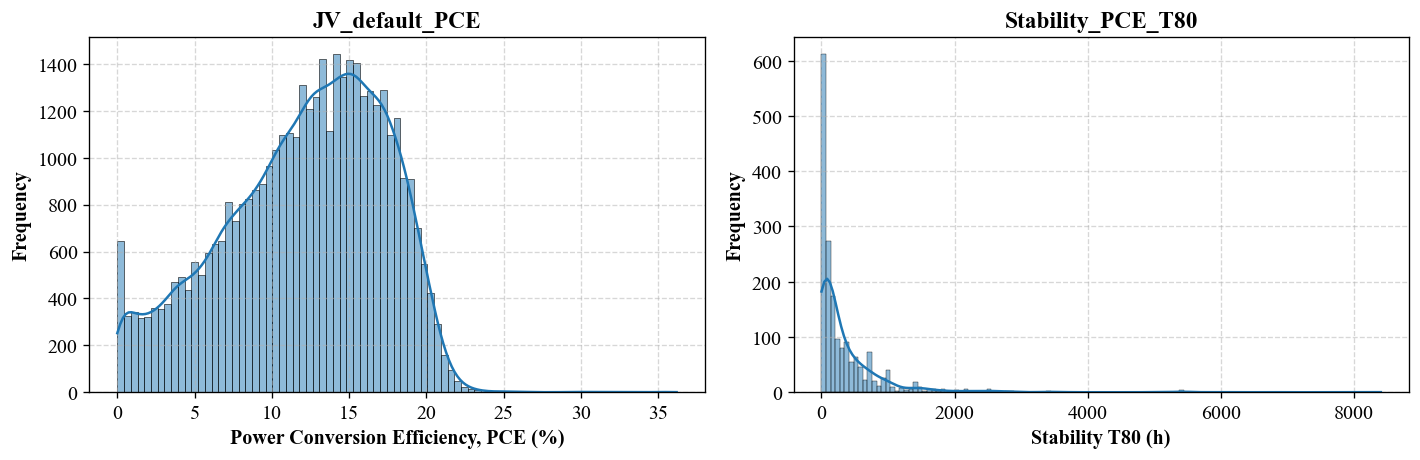

Using third axis: Pb
Saved: 2.png (300 DPI) and 2.pdf


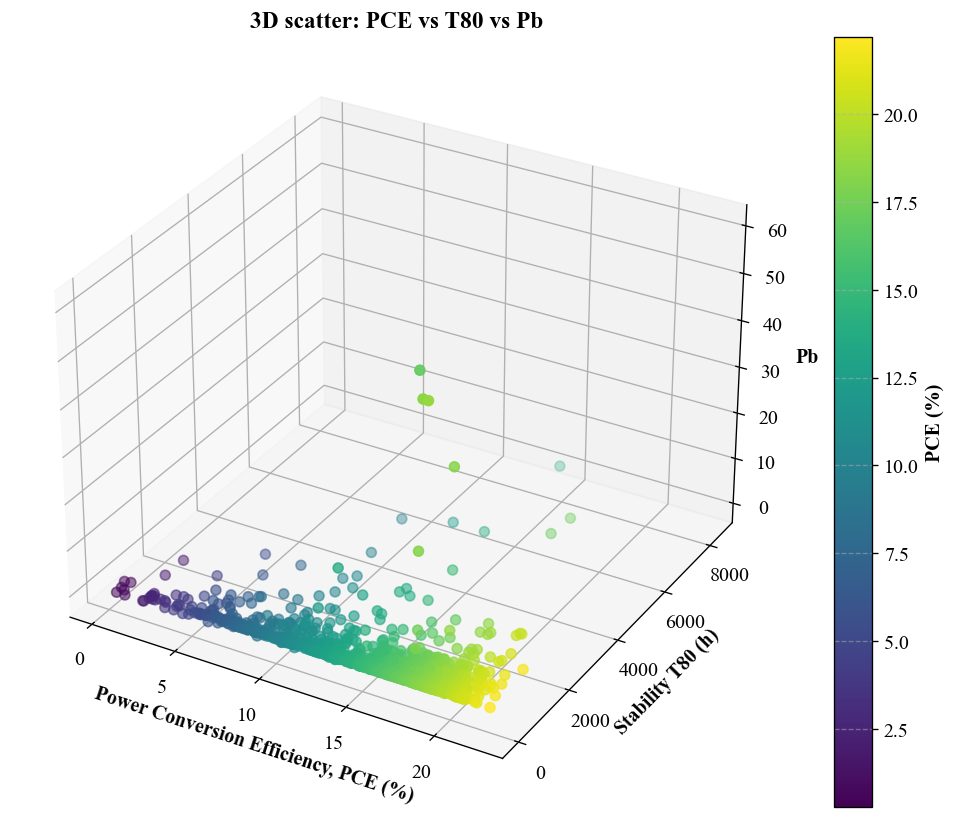

In [3]:
# step2_load_eda.py

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import seaborn as sns

# ---------------------------
# Global matplotlib settings 
# ---------------------------
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "figure.dpi": 120,
    "savefig.dpi": 600
})

# ---------------------------
# Helper: save figures in IEEE style (PNG 300 DPI + PDF)
# ---------------------------
def save_ieee_figure(fig, basename, png_dpi=300):
    """
    Save figure in PNG (300 dpi) and PDF with IEEE formatting.
    Ensures Times New Roman, bold titles/labels, consistent sizes,
    gridlines for clarity, tight layout, and legend styling if present.
    """
    for ax in fig.get_axes():
        # Titles and axis labels in bold / Times New Roman
        ax.set_title(ax.get_title(), fontname="Times New Roman", fontsize=14, fontweight="bold")
        ax.set_xlabel(ax.get_xlabel(), fontname="Times New Roman", fontsize=12, fontweight="bold")
        ax.set_ylabel(ax.get_ylabel(), fontname="Times New Roman", fontsize=12, fontweight="bold")
        if hasattr(ax, "set_zlabel"):  # 3D plots
            ax.set_zlabel(ax.get_zlabel(), fontname="Times New Roman", fontsize=12, fontweight="bold")

        # Ticks
        ax.tick_params(axis="both", labelsize=12)
        for lbl in ax.get_xticklabels() + ax.get_yticklabels():
            lbl.set_fontname("Times New Roman")
        if hasattr(ax, "get_zticklabels"):
            for lbl in ax.get_zticklabels():
                lbl.set_fontname("Times New Roman")

        # Legend (if exists) — ensure clarity
        leg = ax.get_legend()
        if leg:
            for text in leg.get_texts():
                text.set_fontname("Times New Roman")
                text.set_fontsize(11)
            leg.set_frame_on(True)
            leg.get_frame().set_alpha(0.9)

        # Gridlines for readability
        ax.grid(True, linestyle="--", alpha=0.5)

    fig.tight_layout()
    fig.savefig(f"{basename}.png", dpi=png_dpi, bbox_inches="tight")
    fig.savefig(f"{basename}.pdf", dpi=300, bbox_inches="tight")
    print(f"Saved: {basename}.png ({png_dpi} DPI) and {basename}.pdf")

# ---------------------------
# Optional helpers you can use later (kept separate so core logic is untouched)
# ---------------------------
def annotate_r2(ax, x, y):
    """Add R² annotation to regression plots (call where applicable)."""
    x = np.asarray(x)
    y = np.asarray(y)
    mask = np.isfinite(x) & np.isfinite(y)
    if mask.sum() >= 2:
        r = np.corrcoef(x[mask], y[mask])[0, 1]
        r2 = r ** 2
        ax.text(
            0.05, 0.95, f"$R^2$ = {r2:.3f}",
            transform=ax.transAxes, ha="left", va="top",
            fontsize=12, fontname="Times New Roman"
        )

def format_time_axis(ax):
    """Format time axis with clear major ticks only (use in time-series)."""
    import matplotlib.dates as mdates
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
    for lbl in ax.get_xticklabels():
        lbl.set_fontname("Times New Roman")
        lbl.set_fontsize(12)

# ---------------------------
# Load data
# ---------------------------
df = pd.read_excel("Descriptors_Perovskite_Database.xlsx", sheet_name=0)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# ---------------------------
# Basic statistics for targets
# ---------------------------
for t in ["JV_default_PCE", "Stability_PCE_T80"]:
    if t in df.columns:
        print(f"\nTarget {t} — count non-null: {df[t].notna().sum()}, mean: {df[t].mean():.3f}, std: {df[t].std():.3f}")
    else:
        print(f"Warning: {t} not found in dataset")

# ---------------------------
# Plot distributions
# ---------------------------
plt.figure(figsize=(12, 4))
for i, t in enumerate(["JV_default_PCE", "Stability_PCE_T80"]):
    plt.subplot(1, 2, i + 1)
    if t in df.columns:
        sns.histplot(df[t].dropna(), kde=True)
        plt.title(t)
        # Descriptive axis labels (with units where appropriate)
        if t == "JV_default_PCE":
            plt.xlabel("Power Conversion Efficiency, PCE (%)")
        elif t == "Stability_PCE_T80":
            plt.xlabel("Stability T80 (h)")
        else:
            plt.xlabel(t)
        plt.ylabel("Frequency")
    else:
        plt.title(f"{t} missing")
        plt.xlabel("")
        plt.ylabel("")

plt.tight_layout()
save_ieee_figure(plt.gcf(), "1")  # Saves 1.png (300 DPI) and 1.pdf
plt.show()

# ---------------------------
# 3D scatter: PCE vs T80 vs a numeric proxy
# ---------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
third_axis = None
for c in ["Pb", "Sn", "ETL_thickness", "HTL_thickness_list"]:
    if c in numeric_cols:
        third_axis = c
        break
if third_axis is None:
    if "JV_default_PCE" in numeric_cols:
        corrs = df[numeric_cols].corrwith(df["JV_default_PCE"]).abs().sort_values(ascending=False)
        third_axis = corrs.index[1] if len(corrs) > 1 else numeric_cols[0]
    else:
        third_axis = numeric_cols[0]

print("Using third axis:", third_axis)

mask = (
    df.get("JV_default_PCE").notna()
    & df.get("Stability_PCE_T80").notna()
    & df.get(third_axis).notna()
)
sub = df.loc[mask, ["JV_default_PCE", "Stability_PCE_T80", third_axis]]
if len(sub) > 1000:
    sub = sub.sample(1000, random_state=42)

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(
    sub["JV_default_PCE"], sub["Stability_PCE_T80"], sub[third_axis],
    c=sub["JV_default_PCE"], cmap='viridis', s=35
)

# Descriptive labels with units
ax.set_xlabel("Power Conversion Efficiency, PCE (%)")
ax.set_ylabel("Stability T80 (h)")
ax.set_zlabel(third_axis)

cb = fig.colorbar(p, label='PCE (%)')
ax.set_title("3D scatter: PCE vs T80 vs " + third_axis)

plt.tight_layout()
save_ieee_figure(fig, "2")  # Saves 2.png (300 DPI) and 2.pdf
plt.show()

In [4]:
# step3_preprocess.py

# 3A: Identify features to use
TARGET1 = "JV_default_PCE"
TARGET2 = "Stability_PCE_T80"

# Drop obvious non-informative text columns
text_cols = [c for c in df.columns if df[c].dtype == object]
# keep composition long form string for grouping but drop from features
if "Perovskite_composition_long_form" in text_cols:
    text_cols.remove("Perovskite_composition_long_form")
# We'll also keep stack sequence and deposition procedure as categorical features
categorical_keep = ["HTL_stack_sequence", "ETL_stack_sequence", "Perovskite_deposition_procedure", 
                    "HTL_deposition_procedure", "ETL_deposition_procedure"]
categorical_keep = [c for c in categorical_keep if c in df.columns]

# Numeric features: all numeric columns except targets
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in [TARGET1, TARGET2]]

print("Numeric feature count:", len(numeric_cols), "Categorical features:", categorical_keep)

# 3B: New derived features (simple and robust)
def add_derived_features(dff):
    d = dff.copy()
    # A-site total if columns exist
    a_cols = [c for c in ["MA","FA","Cs","others_A"] if c in d.columns]
    b_cols = [c for c in ["Pb","Sn","Ge","others_B"] if c in d.columns]
    halide_cols = [c for c in ["I","Br","Cl","others_X"] if c in d.columns]  # may not exist
    if len(a_cols)>0:
        d["A_total"] = d[a_cols].sum(axis=1)
    if len(b_cols)>0:
        d["B_total"] = d[b_cols].sum(axis=1)
        # pb fraction if Pb present
        if "Pb" in d.columns:
            d["Pb_fraction"] = d["Pb"] / (d[b_cols].sum(axis=1).replace(0, np.nan))
    # interaction features: numeric * A_total (where possible)
    if "A_total" in d.columns:
        for c in numeric_cols:
            # avoid overly many interactions — restrict to handful
            if c in ["annealing_temperature", "annealing_time", "HTL_thickness_list", "ETL_thickness"]:
                d[f"{c}_x_A_total"] = d[c] * d["A_total"]
    return d

df2 = add_derived_features(df)

# 3C: Build feature matrix X and mask for targets
feature_cols = numeric_cols + [c for c in categorical_keep if c in df2.columns] + [c for c in df2.columns if c.endswith("_fraction") or c.endswith("_total")]
# filter to only existing columns
feature_cols = [c for c in feature_cols if c in df2.columns]
print("Using feature columns:", len(feature_cols))

# Prepare datasets for surrogate training:
X = df2[feature_cols].copy()
y1 = df2[TARGET1].copy()
y2 = df2[TARGET2].copy()

# 3D: simple missingness summary
missing_summary = X.isna().mean().sort_values(ascending=False).head(20)
print("Top 20 features by missing fraction:\n", missing_summary)

# 3D: imputers and encoders
num_feats = X.select_dtypes(include=[np.number]).columns.tolist()
cat_feats = [c for c in X.columns if c not in num_feats]

num_imp = SimpleImputer(strategy="median")
X_num = pd.DataFrame(num_imp.fit_transform(X[num_feats]), columns=num_feats, index=X.index)

if len(cat_feats)>0:
    enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_cat_raw = X[cat_feats].fillna("MISSING")
    X_cat = pd.DataFrame(enc.fit_transform(X_cat_raw), columns=cat_feats, index=X.index)
else:
    X_cat = pd.DataFrame(index=X.index)

# scale numeric features
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=num_feats, index=X.index)

# final X
X_proc = pd.concat([X_num_scaled, X_cat], axis=1)
print("Final processed X shape:", X_proc.shape)

# Save objects for reproducibility
joblib.dump({"num_feats":num_feats, "cat_feats":cat_feats, "num_imp":num_imp, "enc":enc if len(cat_feats)>0 else None, "scaler":scaler}, "preprocessing_objects.joblib")

Numeric feature count: 35 Categorical features: ['HTL_stack_sequence', 'ETL_stack_sequence', 'Perovskite_deposition_procedure', 'HTL_deposition_procedure', 'ETL_deposition_procedure']
Using feature columns: 45
Top 20 features by missing fraction:
 Perovskite_deposition_thermal_annealing_relative_humidity       0.996469
HTL_deposition_synthesis_atmosphere_relative_humidity           0.994537
ETL_deposition_synthesis_atmosphere_relative_humidity           0.992819
Perovskite_deposition_synthesis_atmosphere_relative_humidity    0.983729
HTL_thickness_list_x_A_total                                    0.763885
HTL_thickness_list                                              0.763885
ETL_thickness_x_A_total                                         0.563079
ETL_thickness                                                   0.563079
Perovskite_band_gap                                             0.244036
Backcontact_thickness_list                                      0.186850
Perovskite_annealing_t

['preprocessing_objects.joblib']

In [6]:
# ===== Block 1: setup + imports =====
# If you need to install once, run in a terminal:
# pip install pandas numpy matplotlib scikit-learn lightgbm openpyxl

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Path to your file (adjust if needed)
DATA_PATH = Path("./Descriptors_Perovskite_Database.xlsx")

print("Working dir:", os.getcwd())
print("File exists:", DATA_PATH.exists())

Working dir: C:\Users\kanakaraju\IIIT Vadodara- Project
File exists: True


In [7]:
# ===== Block 2: load + audit =====
assert DATA_PATH.exists(), "Dataset file not found. Fix DATA_PATH."

# Load first sheet by default
df = pd.read_excel(DATA_PATH, sheet_name=0)
print("Shape:", df.shape)

# Quick column & dtype summary
dtypes_summary = df.dtypes.value_counts()
print("\nDtype counts:\n", dtypes_summary)

print("\nFirst 5 rows:")
display(df.head(5))

# Targets we will use
TARGET_PCE = "JV_default_PCE"
TARGET_T80 = "Stability_PCE_T80"

# Check target presence and missingness
def col_status(col):
    if col not in df.columns:
        return f"{col}: NOT FOUND"
    n = df[col].notna().sum()
    return f"{col}: present | non-null={n} / {len(df)}"

print("\nTarget status:")
print(col_status(TARGET_PCE))
print(col_status(TARGET_T80))

# Basic duplicate check on composition string (kept for grouping later)
comp_col = "Perovskite_composition_long_form"
if comp_col in df.columns:
    dup_n = df.duplicated(subset=[comp_col]).sum()
    print(f"\nDuplicates by '{comp_col}':", dup_n)
else:
    print(f"\n'{comp_col}' not in dataset (that’s ok).")

# Replace obvious infinities early (safety); DO NOT modify in place yet
df_sanity = df.replace([np.inf, -np.inf], np.nan)
print("\nAny whole-column NaNs? ->", bool(df_sanity.isna().all().any()))

Shape: (41916, 47)

Dtype counts:
 float64    36
object      9
int64       1
bool        1
Name: count, dtype: int64

First 5 rows:


,Perovskite_composition_long_form,LLE_1,LLE_2,LLE_3,LLE_4,MA,FA,Cs,others_A,Pb,...,HTL_stack_sequence,HTL_deposition_procedure,Perovskite_composition_perovskite_ABC3_structure,Backcontact_stack_sequence,Perovskite_deposition_procedure,JV_default_Voc,JV_default_Jsc,JV_default_FF,JV_default_PCE,Stability_PCE_T80
0,CsSnI3,0.011637,-0.035685,-0.028702,0.063775,0.0,0.0,1.0,0.0,0.0,...,Spiro-MeOTAD,Spin-coating,True,Au,Spin-coating,0.002,0.22,0.57,0.00,NaN
1,CsSnBr0.3I2.7,0.011237,-0.038167,-0.031772,0.056723,0.0,0.0,1.0,0.0,0.0,...,Spiro-MeOTAD,Spin-coating,True,Au,Spin-coating,0.120,0.49,0.25,0.00,NaN
2,CsSnBr1.5I1.5,0.008837,-0.046394,-0.046873,0.027959,0.0,0.0,1.0,0.0,0.0,...,Spiro-MeOTAD,Spin-coating,True,Au,Spin-coating,0.135,3.69,0.26,0.13,NaN
3,CsSnBr2.7I0.3,0.006810,-0.055067,-0.062029,-0.001109,0.0,0.0,1.0,0.0,0.0,...,Spiro-MeOTAD,Spin-coating,True,Au,Spin-coating,0.227,1.32,0.41,0.12,NaN
4,CsSnBr3,0.005715,-0.057026,-0.066553,-0.007308,0.0,0.0,1.0,0.0,0.0,...,Spiro-MeOTAD,Spin-coating,True,Au,Spin-coating,0.190,1.57,0.34,0.10,NaN



Target status:
JV_default_PCE: present | non-null=40987 / 41916
Stability_PCE_T80: present | non-null=1805 / 41916

Duplicates by 'Perovskite_composition_long_form': 39994

Any whole-column NaNs? -> False


In [8]:
# ===== Block 4: preprocessing (robust & reproducible) =====
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import joblib

# --- 4.1: targets and columns of interest ---
TARGET_PCE = "JV_default_PCE"
TARGET_T80 = "Stability_PCE_T80"
keep_categoricals = [
    "ETL_stack_sequence",
    "HTL_stack_sequence",
    "Perovskite_deposition_procedure",
    "ETL_deposition_procedure",
    "HTL_deposition_procedure",
]
keep_categoricals = [c for c in keep_categoricals if c in df.columns]

# --- 4.2: simple physics-aware derived features (optional but helpful) ---
def add_derived_features(dff: pd.DataFrame) -> pd.DataFrame:
    d = dff.copy()

    # Sums/fractions for A/B sites if present
    a_cols = [c for c in ["MA","FA","Cs","others_A"] if c in d.columns]
    b_cols = [c for c in ["Pb","Sn","Ge","others_B"] if c in d.columns]

    if a_cols:
        d["A_total"] = d[a_cols].sum(axis=1)
    if b_cols:
        d["B_total"] = d[b_cols].sum(axis=1)
        if "Pb" in d.columns:
            denom = d[b_cols].sum(axis=1).replace(0, np.nan)
            d["Pb_fraction"] = d["Pb"] / denom

    # A few robust interactions (only if columns exist)
    for base in ["annealing_temperature", "annealing_time", "HTL_thickness_list", "ETL_thickness"]:
        if base in d.columns and "A_total" in d.columns:
            d[f"{base}_x_A_total"] = d[base] * d["A_total"]

    return d

df2 = add_derived_features(df)

# --- 4.3: define feature sets ---
num_cols_all = df2.select_dtypes(include=[np.number]).columns.tolist()
# Exclude targets from numeric features
num_cols = [c for c in num_cols_all if c not in [TARGET_PCE, TARGET_T80]]
cat_cols = keep_categoricals  # we will encode these

print(f"[Info] numeric features: {len(num_cols)} | categorical features: {len(cat_cols)}")

# --- 4.4: split features/targets (keep raw copies for reference) ---
X_num_raw = df2[num_cols].copy()
X_cat_raw = df2[cat_cols].copy() if cat_cols else pd.DataFrame(index=df2.index)

y1 = df2[TARGET_PCE] if TARGET_PCE in df2.columns else pd.Series(index=df2.index, dtype=float)
y2 = df2[TARGET_T80] if TARGET_T80 in df2.columns else pd.Series(index=df2.index, dtype=float)

# --- 4.5: impute + encode + scale (robust to NaNs) ---
# 4.5.1 numeric imputer
num_imp = SimpleImputer(strategy="median")
X_num_imp = pd.DataFrame(num_imp.fit_transform(X_num_raw), columns=num_cols, index=df2.index)

# 4.5.2 categorical encoder (ordinal; unknowns -> -1)
if cat_cols:
    enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_cat_filled = X_cat_raw.fillna("MISSING")
    X_cat_enc = pd.DataFrame(enc.fit_transform(X_cat_filled), columns=cat_cols, index=df2.index)
else:
    enc = None
    X_cat_enc = pd.DataFrame(index=df2.index)

# 4.5.3 scale numerics
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num_imp), columns=num_cols, index=df2.index)

# --- 4.6: assemble processed matrix & hard-sanitize ---
X_proc = pd.concat([X_num_scaled, X_cat_enc], axis=1)
# Replace infs -> NaN -> fill with 0; drop any all-NaN columns (paranoid)
X_proc = X_proc.replace([np.inf, -np.inf], np.nan)
all_nan_cols = X_proc.columns[X_proc.isna().all()]
if len(all_nan_cols) > 0:
    print("[Warn] Dropping all-NaN columns:", list(all_nan_cols))
    X_proc = X_proc.drop(columns=list(all_nan_cols))
# Final fill (safe after standardization)
X_proc = X_proc.fillna(0.0)

# --- 4.7: quick sanity prints ---
print("X_proc shape:", X_proc.shape)
print("Any NaNs in X_proc? ->", X_proc.isna().any().any())
print("Non-null targets -> PCE:", int(y1.notna().sum()), "| T80:", int(y2.notna().sum()))

# --- 4.8: persist preprocessors for reuse (NSGA-II / MOBO steps will need them) ---
prepro_bundle = {
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "num_imp": num_imp,
    "enc": enc,
    "scaler": scaler,
    "target_names": {"pce": TARGET_PCE, "t80": TARGET_T80},
}
joblib.dump(prepro_bundle, "preprocessing_objects.joblib")
print("Saved: preprocessing_objects.joblib")

[Info] numeric features: 40 | categorical features: 5
X_proc shape: (41916, 45)
Any NaNs in X_proc? -> False
Non-null targets -> PCE: 40987 | T80: 1805
Saved: preprocessing_objects.joblib


In [9]:
# ===== Block 5R — FINAL PATCH (no verbose_eval, no early_stopping) =====
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import lightgbm as lgb
from pathlib import Path
import joblib

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
TARGET_PCE = "JV_default_PCE"
COMP_COL = "Perovskite_composition_long_form"

# 1) Strict-clean features & targets
X_strict = X_proc.copy().replace([np.inf, -np.inf], np.nan).fillna(0.0)
y1_strict = pd.to_numeric(y1, errors="coerce")

mask = np.isfinite(X_strict.values).all(axis=1) & y1_strict.notna().values & np.isfinite(y1_strict.values)
X_ok = X_strict.loc[mask]
y_ok = y1_strict.loc[mask]
print(f"[PCE] rows usable: {len(X_ok)}")

assert len(X_ok) >= 20, "Too few valid rows; re-run Blocks 1–4."

# 2) NaN-safe grouped split (or random fallback)
if COMP_COL in df.columns:
    groups = df.loc[X_ok.index, COMP_COL].astype(str).replace(["nan","None"], "MISSING_GROUP").fillna("MISSING_GROUP")
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
    tr_idx, te_idx = next(gss.split(X_ok, y_ok, groups=groups))
    X_tr, X_te = X_ok.iloc[tr_idx], X_ok.iloc[te_idx]
    y_tr, y_te = y_ok.iloc[tr_idx], y_ok.iloc[te_idx]
    print(f"[Split] Grouped by '{COMP_COL}': train={len(X_tr)}, test={len(X_te)}")
else:
    X_tr, X_te, y_tr, y_te = train_test_split(X_ok, y_ok, test_size=0.2, random_state=RANDOM_SEED)
    print(f"[Split] Random: train={len(X_tr)}, test={len(X_te)}")

def ensure_finite(X, y, tag):
    ok = np.isfinite(X.values).all(axis=1) & np.isfinite(y.values)
    if ok.sum() < len(ok):
        print(f"[{tag}] dropping {len(ok)-ok.sum()} non-finite rows")
        X = X.iloc[ok]; y = y.iloc[ok]
    return X, y

X_tr, y_tr = ensure_finite(X_tr, y_tr, "Train")
X_te, y_te = ensure_finite(X_te, y_te, "Test")

# 3) Train LightGBM ensemble (native API; fixed rounds; NO verbose_eval)
def train_lgb_ensemble_fixed(X_train, y_train, n_ens=7, seed=42):
    models = []
    rng = np.random.RandomState(seed)
    n = len(X_train)
    for i in range(n_ens):
        idx = np.arange(n) if n < 5 else rng.choice(n, size=max(5, int(0.8*n)), replace=True)
        Xb = X_train.iloc[idx]; yb = y_train.iloc[idx]
        dtrain = lgb.Dataset(Xb, label=yb)
        params = {
            "objective": "regression",
            "metric": "rmse",
            "verbosity": -1,
            "boosting_type": "gbdt",
            "num_leaves": 64,
            "learning_rate": 0.02,
            "feature_fraction": 0.85,
            "bagging_fraction": 0.8,
            "bagging_freq": 1
        }
        model = lgb.train(params, dtrain, num_boost_round=500)  # <-- only these args
        models.append(model)
    return models

pce_models = train_lgb_ensemble_fixed(X_tr, y_tr, n_ens=7, seed=RANDOM_SEED)
print("Trained PCE ensemble:", len(pce_models))

# 4) Predict + metrics (NaN-safe)
def ensemble_predict_safe(models, Xq):
    if not models: return np.zeros(len(Xq)), np.zeros(len(Xq))
    P = np.vstack([m.predict(Xq) for m in models]).astype(float)
    mean = np.nanmean(P, axis=0)
    std  = np.nanstd(P, axis=0)
    mean = np.nan_to_num(mean, nan=0.0, posinf=0.0, neginf=0.0)
    std  = np.nan_to_num(std,  nan=0.0, posinf=0.0, neginf=0.0)
    return mean, std

p_mean, _ = ensemble_predict_safe(pce_models, X_te)
ok = np.isfinite(p_mean) & np.isfinite(y_te.values)
if ok.sum() < len(ok):
    print(f"[Eval] dropping {len(ok)-ok.sum()} rows due to non-finite y/pred")
p_mean = p_mean[ok]; y_eval = y_te.values[ok]

print(f"[PCE] quick R²={r2_score(y_eval, p_mean):.4f} | RMSE={np.sqrt(mean_squared_error(y_eval, p_mean)):.3f} | MAE={mean_absolute_error(y_eval, p_mean):.3f}")

# 5) Save PCE models so Block 6 can always load them
out_dir = Path("./artifacts_block5_strict")
out_dir.mkdir(parents=True, exist_ok=True)
model_paths = []
for i, m in enumerate(pce_models):
    path = out_dir / f"lgb_pce_model_{i}.txt"
    m.save_model(str(path))
    model_paths.append(str(path))
manifest = {"models": model_paths, "target": TARGET_PCE, "random_seed": RANDOM_SEED}
joblib.dump(manifest, out_dir / "pce_manifest.joblib")
print("Saved PCE models to:", out_dir.resolve())

[PCE] rows usable: 40987
[Split] Grouped by 'Perovskite_composition_long_form': train=38392, test=2595
Trained PCE ensemble: 7
[PCE] quick R²=0.9665 | RMSE=1.166 | MAE=0.553
Saved PCE models to: C:\Users\kanakaraju\IIIT Vadodara- Project\artifacts_block5_strict


Saved: fig_block6_1.png (300 DPI) and fig_block6_1.pdf


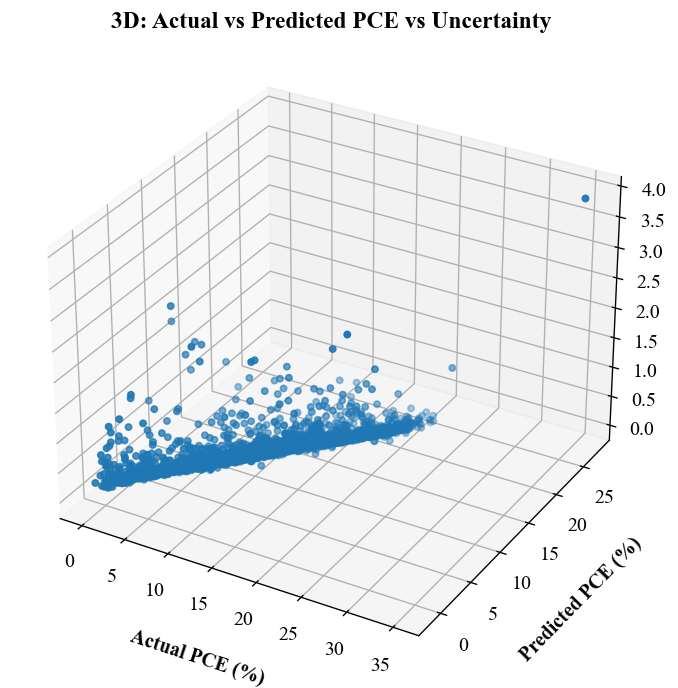

Saved: fig_block6_2.png (300 DPI) and fig_block6_2.pdf


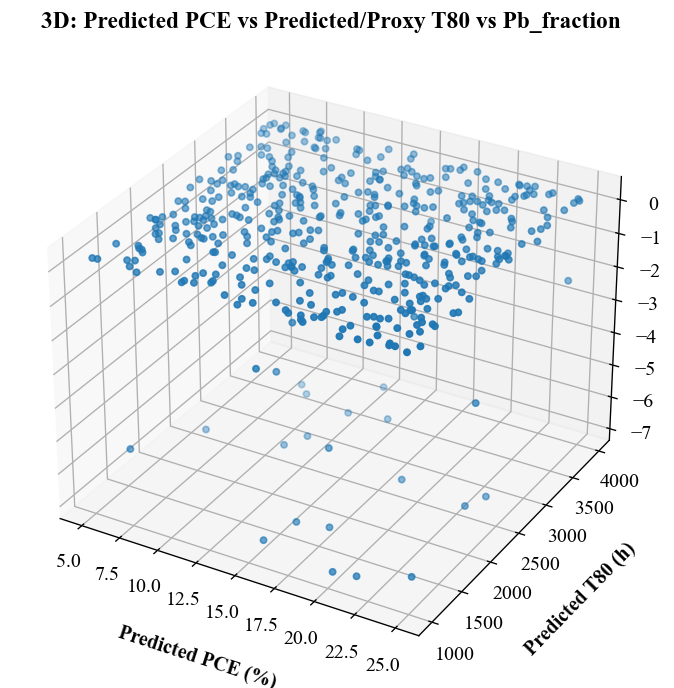

In [19]:
# ---------- Imports ----------
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


# ---------- Utilities ----------
def _align_xyz(*arrs):
    """Make x/y/z arrays the same length and drop NaNs/Infs."""
    arrs = [np.asarray(a).ravel() for a in arrs]
    L = min(map(len, arrs))
    arrs = [a[:L] for a in arrs]
    mask = np.logical_and.reduce([np.isfinite(a) for a in arrs])
    return [a[mask] for a in arrs]


# ---------- IEEE helper (robust for 3D; does NOT overwrite label text) ----------
def save_ieee_figure(fig, basename, png_dpi=300, tight=False):
    """
    Save figure in PNG (300 dpi) and PDF with IEEE-friendly styling.
    For 3D axes, tight=False is safest to avoid cropping labels.
    """
    for ax in fig.get_axes():
        # Title font only (keep existing text)
        ax.set_title(ax.get_title(), fontname="Times New Roman",
                     fontsize=14, fontweight="bold")

        # Axis-label font only (keep existing text)
        ax.xaxis.label.set_fontname("Times New Roman")
        ax.xaxis.label.set_fontsize(12)
        ax.xaxis.label.set_fontweight("bold")

        ax.yaxis.label.set_fontname("Times New Roman")
        ax.yaxis.label.set_fontsize(12)
        ax.yaxis.label.set_fontweight("bold")

        if hasattr(ax, "zaxis"):
            ax.zaxis.label.set_fontname("Times New Roman")
            ax.zaxis.label.set_fontsize(12)
            ax.zaxis.label.set_fontweight("bold")
            # Let MPL rotate z-label along the axis (helps bbox)
            try:
                ax.zaxis.set_rotate_label(True)
            except Exception:
                pass

        # Tick styling
        ax.tick_params(axis="both", labelsize=12, pad=4)
        try:
            for lbl in ax.get_xticklabels() + ax.get_yticklabels():
                lbl.set_fontname("Times New Roman")
        except Exception:
            pass
        if hasattr(ax, "get_zticklabels"):
            for lbl in ax.get_zticklabels():
                lbl.set_fontname("Times New Roman")

        # Legend styling
        leg = ax.get_legend()
        if leg:
            for text in leg.get_texts():
                text.set_fontname("Times New Roman")
                text.set_fontsize(11)
            leg.set_frame_on(True)
            leg.get_frame().set_alpha(0.9)

        ax.grid(True, linestyle="--", alpha=0.5)

    # Draw once so bboxes exist
    fig.canvas.draw()

    if tight:
        fig.savefig(f"{basename}.png", dpi=png_dpi,
                    bbox_inches="tight", pad_inches=0.3)
        fig.savefig(f"{basename}.pdf", dpi=300,
                    bbox_inches="tight", pad_inches=0.3)
    else:
        fig.savefig(f"{basename}.png", dpi=png_dpi)
        fig.savefig(f"{basename}.pdf", dpi=300)

    print(f"Saved: {basename}.png ({png_dpi} DPI) and {basename}.pdf")


# ===================== 3D FIGURES =====================

# ---------- 6.3 3D Figure 1 ----------
# If you have ensemble predictions in 2D, ensure p_mean/p_std are per-sample:
# preds_ens shape either (N, M) or (M, N); comment out if already computed.
# preds_ens = np.asarray(preds_ens)
# N = len(y_plot)
# if preds_ens.ndim == 2 and preds_ens.shape[0] == N:
#     p_mean = preds_ens.mean(axis=1)
#     p_std  = preds_ens.std(axis=1)
# elif preds_ens.ndim == 2 and preds_ens.shape[1] == N:
#     p_mean = preds_ens.mean(axis=0)
#     p_std  = preds_ens.std(axis=0)

# Align and clean arrays to avoid shape-mismatch/NaNs
y1, pm1, ps1 = _align_xyz(y_plot, p_mean, p_std)

fig = plt.figure(figsize=(9, 7))           # 
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y1, pm1, ps1, s=14)

# Labels (set text here; helper only styles)
ax.set_xlabel("Actual PCE (%)", labelpad=14)
ax.set_ylabel("Predicted PCE (%)", labelpad=14)
ax.set_zlabel("Uncertainty σ (ensemble)", labelpad=20, rotation=90)
ax.set_title("3D: Actual vs Predicted PCE vs Uncertainty")

# Extra margins so labels never clip
fig.subplots_adjust(left=0.20, right=0.96, bottom=0.16, top=0.92)

save_ieee_figure(fig, "fig_block6_1", tight=False)  # safest for 3D
plt.show()


# ---------- 6.4 3D Figure 2 ----------
x2, y2, z2 = _align_xyz(p_mean2, t_mean2, z_vals)

fig = plt.figure(figsize=(9, 7))           # 
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x2, y2, z2, s=14)

ax.set_xlabel("Predicted PCE (%)", labelpad=14)
ax.set_ylabel(y_label_t80, labelpad=14)
ax.set_zlabel(third_axis, labelpad=20, rotation=90)
ax.set_title("3D: Predicted PCE vs Predicted/Proxy T80 vs " + third_axis)

fig.subplots_adjust(left=0.20, right=0.96, bottom=0.16, top=0.92)

save_ieee_figure(fig, "fig_block6_2", tight=False)
plt.show()

Decision space:
 - HTL_thickness_list                            CONT [8,400]
 - ETL_thickness                                 CONT [2,1.19e+03]
 - Perovskite_deposition_synthesis_atmosphere_relative_humidity CONT [0.0062,75]
 - Perovskite_deposition_procedure               CAT [0..185]
 - HTL_stack_sequence                            CAT [0..1927]
 - ETL_stack_sequence                            CAT [0..1430]
 - HTL_deposition_procedure                      CAT [0..118]
 - ETL_deposition_procedure                      CAT [0..360]
T80 surrogate available: True
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      3 |             - |             -
     2 |      200 |      5 |  0.0562464517 |         ideal
     3 |      300 |      5 |  0.0245861875 |         ideal
     4 |      400 |      5 |  0.5336512422 |         ideal
     5 |      500 |      7 |  0.0466565745 |         ideal
     6 |      600 |      7 |  0.0971114514 |         ideal
     7 |      700 |

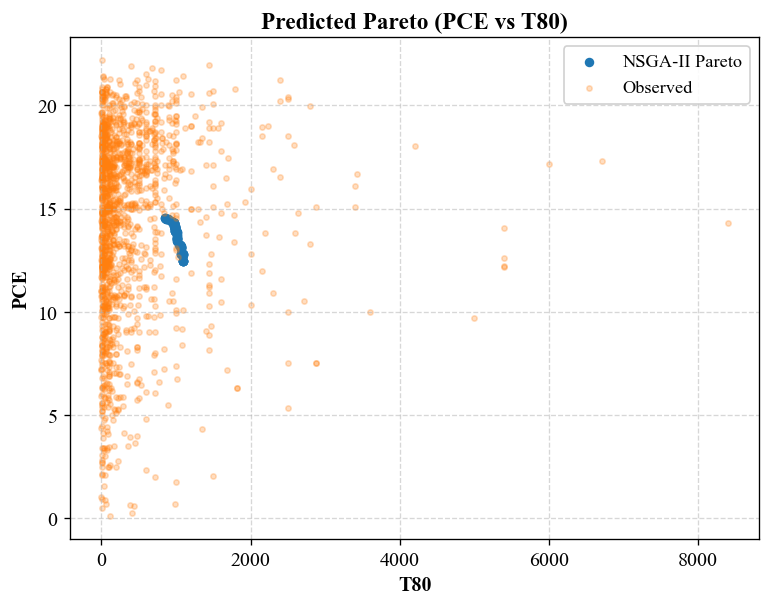

Saved: artifacts_block7\pareto_3d.png (300 DPI) and artifacts_block7\pareto_3d.pdf


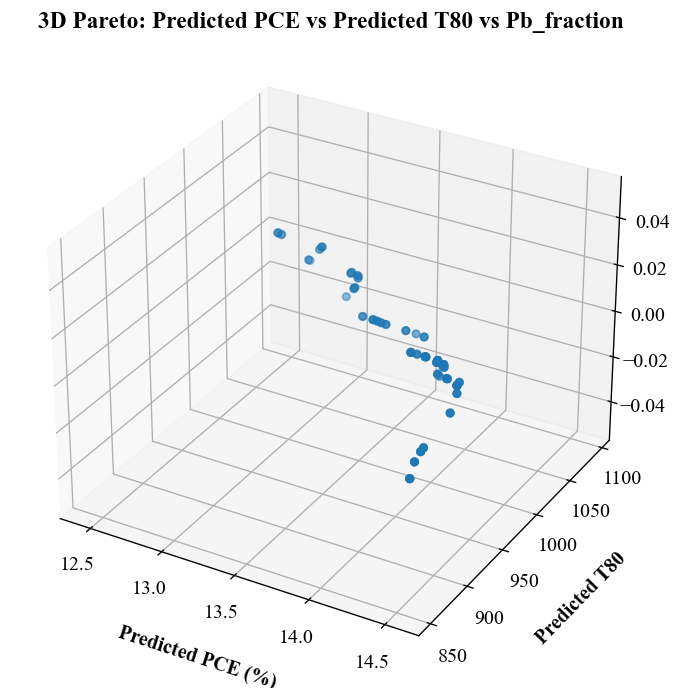

Artifacts in: C:\Users\kanakaraju\IIIT Vadodara- Project\artifacts_block7
Files: ['nsga2_pareto_candidates.csv', 'pareto_2d.pdf', 'pareto_2d.png', 'pareto_3d.pdf', 'pareto_3d.png']


In [20]:
# ===== Block 7 (pymoo ≥ 0.6): NSGA-II Pareto search (PCE ↑, T80 ↑) =====
# Prereqs: Blocks 1–6 done; have df, X_proc, y1, pce_models (req), t80_models (opt)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import joblib

# ---- pymoo 0.6+ imports (no factory) ----
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

# ---------- IEEE helper (robust for 2D/3D; styles fonts only) ----------
def save_ieee_figure(fig, basename, png_dpi=300, tight=False):
    """
    Save figure in PNG (300 dpi) and PDF with IEEE-friendly styling.
    For 3D axes, keep tight=False to avoid cropping labels.
    """
    for ax in fig.get_axes():
        # Title font
        ax.set_title(ax.get_title(), fontname="Times New Roman",
                     fontsize=14, fontweight="bold")

        # Axis label fonts (do not change the text itself)
        ax.xaxis.label.set_fontname("Times New Roman")
        ax.xaxis.label.set_fontsize(12)
        ax.xaxis.label.set_fontweight("bold")

        ax.yaxis.label.set_fontname("Times New Roman")
        ax.yaxis.label.set_fontsize(12)
        ax.yaxis.label.set_fontweight("bold")

        if hasattr(ax, "zaxis"):
            ax.zaxis.label.set_fontname("Times New Roman")
            ax.zaxis.label.set_fontsize(12)
            ax.zaxis.label.set_fontweight("bold")
            try:
                ax.zaxis.set_rotate_label(True)
            except Exception:
                pass

        # Ticks & grid
        ax.tick_params(axis="both", labelsize=12, pad=4)
        try:
            for lbl in ax.get_xticklabels() + ax.get_yticklabels():
                lbl.set_fontname("Times New Roman")
        except Exception:
            pass
        if hasattr(ax, "get_zticklabels"):
            for lbl in ax.get_zticklabels():
                lbl.set_fontname("Times New Roman")

        leg = ax.get_legend()
        if leg:
            for t in leg.get_texts():
                t.set_fontname("Times New Roman")
                t.set_fontsize(11)
            leg.set_frame_on(True)
            leg.get_frame().set_alpha(0.9)

        ax.grid(True, linestyle="--", alpha=0.5)

    fig.canvas.draw()
    if tight:
        fig.savefig(f"{basename}.png", dpi=png_dpi, bbox_inches="tight", pad_inches=0.3)
        fig.savefig(f"{basename}.pdf", dpi=300, bbox_inches="tight", pad_inches=0.3)
    else:
        fig.savefig(f"{basename}.png", dpi=png_dpi)
        fig.savefig(f"{basename}.pdf", dpi=300)
    print(f"Saved: {basename}.png ({png_dpi} DPI) and {basename}.pdf")

def _align_xyz(*arrs):
    """Make arrays same length and drop non-finite values (for safe scatter)."""
    arrs = [np.asarray(a).ravel() for a in arrs]
    L = min(map(len, arrs))
    arrs = [a[:L] for a in arrs]
    mask = np.logical_and.reduce([np.isfinite(a) for a in arrs])
    return [a[mask] for a in arrs]

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
TARGET_PCE = "JV_default_PCE"
TARGET_T80 = "Stability_PCE_T80"

# --- sanity: ensure PCE ensemble available ---
try:
    _ = pce_models
except NameError:
    raise RuntimeError("pce_models not found. Run Block 5R/5 (STRICT) first.")

# --- load preprocessors from Block 4 ---
prepro   = joblib.load("preprocessing_objects.joblib")
num_cols = prepro["num_cols"]
cat_cols = prepro["cat_cols"]
num_imp  = prepro["num_imp"]
enc      = prepro["enc"]
scaler   = prepro["scaler"]

# ---------- 7.1 Decision space ----------
candidate_cont = [c for c in [
    "annealing_temperature",
    "annealing_time",
    "HTL_thickness_list",
    "ETL_thickness",
    "Perovskite_deposition_synthesis_atmosphere_relative_humidity"
] if c in df.columns]

candidate_cat = [c for c in [
    "Perovskite_deposition_procedure",
    "HTL_stack_sequence",
    "ETL_stack_sequence",
    "HTL_deposition_procedure",
    "ETL_deposition_procedure"
] if c in df.columns]

decision_space = []
for c in candidate_cont:
    ser = pd.to_numeric(df[c], errors="coerce")
    lo = float(ser.quantile(0.02)) if ser.notna().any() else 0.0
    hi = float(ser.quantile(0.98)) if ser.notna().any() else 1.0
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = (0.0, 1.0)
    decision_space.append((c, "cont", lo, hi))

cat_choices = {}
for c in candidate_cat:
    vals = df[c].fillna("MISSING").astype(str).unique().tolist()
    cat_choices[c] = vals
    decision_space.append((c, "cat", 0, len(vals) - 1))

if len(decision_space) == 0:
    raise RuntimeError("Decision space is empty. Ensure Block 4 ran and that the chosen knobs exist.")

print("Decision space:")
for name, typ, lo, hi in decision_space:
    rng = f"[{lo:.3g},{hi:.3g}]" if typ == "cont" else f"[0..{int(hi)}]"
    print(f" - {name:45s} {typ.upper():>3s} {rng}")

# ---------- 7.2 Map decision vector -> processed features ----------
X_template_num = pd.Series({c: (pd.to_numeric(df[c], errors="coerce").median() if c in df.columns else 0.0) for c in num_cols})
X_template_cat = pd.Series({c: "MISSING" for c in cat_cols})

def map_decision_to_Xproc(x_vec):
    raw_num = X_template_num.copy()
    raw_cat = X_template_cat.copy()
    j = 0
    # continuous first
    for (name, typ, lo, hi) in decision_space:
        if typ == "cont":
            if name in raw_num.index:
                raw_num[name] = float(x_vec[j])
            j += 1
    # categorical
    for (name, typ, lo, hi) in decision_space:
        if typ == "cat":
            idx = int(round(x_vec[j])); idx = max(0, min(idx, int(hi)))
            val = cat_choices[name][idx]
            if name in raw_cat.index:
                raw_cat[name] = val
            j += 1
    # apply Block 4 preprocessing
    raw_num_df = pd.DataFrame([raw_num])
    num_imp_out = pd.DataFrame(num_imp.transform(raw_num_df), columns=num_cols)
    num_scaled  = pd.DataFrame(scaler.transform(num_imp_out), columns=num_cols)
    if len(cat_cols) > 0 and enc is not None:
        raw_cat_df = pd.DataFrame([raw_cat]).fillna("MISSING")
        cat_enc = pd.DataFrame(enc.transform(raw_cat_df), columns=cat_cols)
    else:
        cat_enc = pd.DataFrame(index=[0])
    X_row = pd.concat([num_scaled.reset_index(drop=True), cat_enc.reset_index(drop=True)], axis=1)
    X_row = X_row.reindex(columns=X_proc.columns, fill_value=0.0)
    return X_row.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# ---------- 7.3 Surrogate predictors ----------
def ensemble_predict_safe(models, Xq):
    if not models:
        return np.zeros(len(Xq)), np.zeros(len(Xq))
    preds = [m.predict(Xq) for m in models]      # list of (1,) or (n,) arrays
    P = np.vstack(preds).astype(float)           # shape (M, n)
    mu = np.nanmean(P, axis=0)                   # -> (n,)
    sd = np.nanstd(P, axis=0)                    # -> (n,)
    return np.nan_to_num(mu), np.nan_to_num(sd)

has_t80 = 't80_models' in globals() and isinstance(t80_models, list) and len(t80_models) > 0
print("T80 surrogate available:", has_t80)

# ---------- 7.4 Pymoo Problem ----------
class SurrogateParetoProblem(Problem):
    def __init__(self, decision_space):
        self.decision_space = decision_space
        xl = []; xu = []
        for (_, _, lo, hi) in decision_space:
            xl.append(float(lo)); xu.append(float(hi))
        super().__init__(n_var=len(decision_space), n_obj=2, xl=np.array(xl), xu=np.array(xu))

    def _evaluate(self, X, out, *args, **kwargs):
        f1 = []; f2 = []
        for i in range(X.shape[0]):
            Xi = X[i, :]
            Xrow = map_decision_to_Xproc(Xi)
            mu_pce, _ = ensemble_predict_safe(pce_models, Xrow)
            if has_t80:
                mu_t80, _ = ensemble_predict_safe(t80_models, Xrow)
                t80_val = float(mu_t80[0])
            else:
                t80_val = float(pd.to_numeric(df[TARGET_T80], errors="coerce").median()) if TARGET_T80 in df.columns else 0.0
            pce_val = float(mu_pce[0])
            f1.append(-pce_val)  # maximize → minimize negative
            f2.append(-t80_val)
        out["F"] = np.column_stack([f1, f2])

problem = SurrogateParetoProblem(decision_space)

# ---------- 7.5 NSGA-II ----------
algorithm = NSGA2(
    pop_size=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

res = minimize(
    problem,
    algorithm,
    ('n_gen', 120),
    seed=RANDOM_SEED,
    verbose=True
)

X_pareto = res.X
F_pareto = -res.F  # back to maximization (PCE, T80)
print("Pareto set size:", len(X_pareto))

# ---------- 7.6 Human-readable candidate table ----------
def vec_to_recipe(vec):
    recipe = {}; j = 0
    for (name, typ, lo, hi) in decision_space:
        if typ == "cont":
            recipe[name] = float(vec[j]); j += 1
    for (name, typ, lo, hi) in decision_space:
        if typ == "cat":
            idx = int(round(vec[j])); idx = max(0, min(idx, int(hi)))
            recipe[name] = cat_choices[name][idx]; j += 1
    return recipe

rows = []
for i in range(len(X_pareto)):
    vec = X_pareto[i]
    pce, t80 = F_pareto[i, 0], F_pareto[i, 1]
    rows.append({"Pred_PCE": float(pce), "Pred_T80": float(t80), **vec_to_recipe(vec)})

cand_df = pd.DataFrame(rows).sort_values(["Pred_PCE","Pred_T80"], ascending=[False, False]).reset_index(drop=True)

out_dir = Path("./artifacts_block7")
out_dir.mkdir(parents=True, exist_ok=True)
csv_path = out_dir / "nsga2_pareto_candidates.csv"
cand_df.to_csv(csv_path, index=False)
print("Saved candidates ->", csv_path.resolve())

# ---------- 7.7 Plots: 2D Pareto + 3D Pareto ----------
# 2D Predicted Pareto
fig = plt.figure(figsize=(7, 5.5))
ax = fig.add_subplot(111)
ax.scatter(cand_df["Pred_T80"], cand_df["Pred_PCE"], s=22, label="NSGA-II Pareto")
if TARGET_PCE in df.columns and TARGET_T80 in df.columns:
    obs_mask = pd.to_numeric(df[TARGET_PCE], errors="coerce").notna() & pd.to_numeric(df[TARGET_T80], errors="coerce").notna()
    if obs_mask.any():
        ax.scatter(df.loc[obs_mask, TARGET_T80], df.loc[obs_mask, TARGET_PCE], s=10, alpha=0.25, label="Observed")

ax.set_xlabel("T80")
ax.set_ylabel("PCE")
ax.set_title("Predicted Pareto (PCE vs T80)")
ax.legend()
fig.subplots_adjust(left=0.16, right=0.98, bottom=0.16, top=0.92)
save_ieee_figure(fig, str(out_dir / "pareto_2d"), tight=True)   # tight is fine for 2D
plt.show()

# 3D: choose an informative Z axis
third_axis = None
for c in ["Pb_fraction", "Pb", "Sn", "ETL_thickness", "HTL_thickness_list"]:
    if c in df.columns:
        third_axis = c; break
    if c in X_proc.columns:
        third_axis = c; break
if third_axis is None:
    var_series = X_proc.select_dtypes(include=[np.number]).var().sort_values(ascending=False)
    third_axis = var_series.index[0] if len(var_series) else "Z"

def z_value_for_plot(zname):
    if zname in df.columns:
        return float(pd.to_numeric(df[zname], errors="coerce").median())
    elif zname in X_proc.columns:
        return 0.0  # standardized feature median
    return 0.0

z_vals = np.array([z_value_for_plot(third_axis)] * len(cand_df))

# 3D Predicted Pareto
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
x2, y2, z2 = _align_xyz(cand_df["Pred_PCE"].values, cand_df["Pred_T80"].values, z_vals)

fig = plt.figure(figsize=(9, 7))   # no constrained_layout for 3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x2, y2, z2, s=20)

ax.set_xlabel("Predicted PCE (%)", labelpad=14)
ax.set_ylabel("Predicted T80",     labelpad=14)
ax.set_zlabel(third_axis,          labelpad=20, rotation=90)
ax.set_title("3D Pareto: Predicted PCE vs Predicted T80 vs " + third_axis)

fig.subplots_adjust(left=0.20, right=0.96, bottom=0.16, top=0.92)
save_ieee_figure(fig, str(out_dir / "pareto_3d"), tight=False)  # safest for 3D
plt.show()

print("Artifacts in:", out_dir.resolve())
print("Files:", [p.name for p in sorted(out_dir.iterdir())])